In [3]:
from environment.models.simple import SimpleEnv

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

env = SimpleEnv()

2024-03-26 11:15:41.653276: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 11:15:41.796264: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


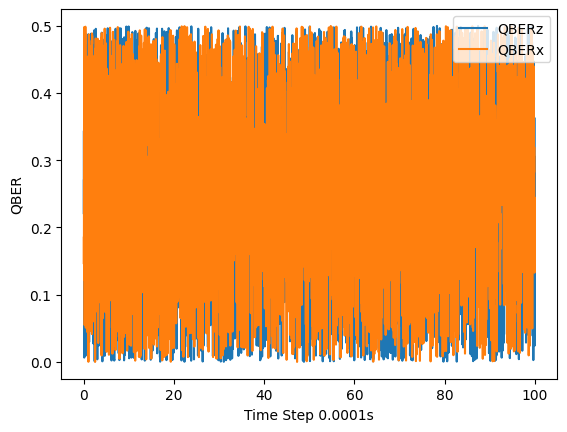

In [4]:
# env.max_t = 100
# env.simulate(reset=True)

# QBER = env.get_QBER()
# PHI = env.get_phi()
# T = env.t_history

# plt.plot(env.t_history, QBER[:,0],label='QBERz')
# plt.plot(env.t_history, QBER[:,1],label='QBERx')
# plt.legend(loc = 'upper right')
# plt.ylabel('QBER')
# plt.xlabel(f'Time Step {env.delta_t}s')
# plt.show()

In [5]:
# np.save('data/QBER_100.npy',QBER)
# np.save('data/PHI_100.npy',PHI)

QBER = np.load('data/QBER_100.npy')
PHI = np.load('data/PHI_100.npy')

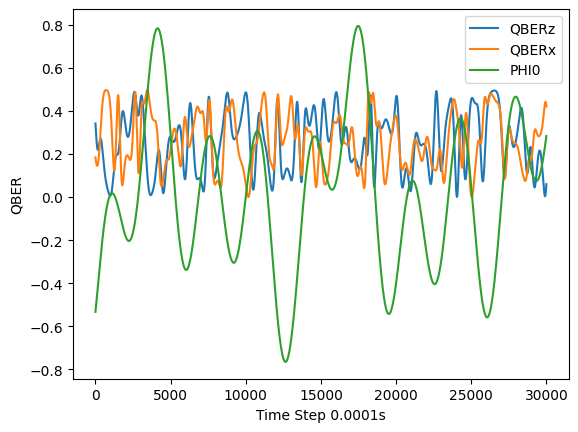

In [6]:
plt.plot( QBER[:30000,0],label='QBERz')
plt.plot( QBER[:30000,1],label='QBERx')
plt.plot( PHI[:30000,0],label='PHI0')
plt.legend(loc = 'upper right')
plt.ylabel('QBER')
plt.xlabel(f'Time Step {env.delta_t}s')
plt.show()

In [7]:
split = .8
train_test_margin = .1
# Split the data into training and testing sets
phi_train = PHI[:int(len(PHI)*split)]
phi_test = PHI[int(len(PHI)*(split-train_test_margin)):]

t_train = np.array(T[:int(len(T)*split)])
t_test = np.array(T[int(len(T)*(split-train_test_margin)):])

QBERs_train = QBER[:int(len(QBER)*split)]
QBERs_test = QBER[int(len(QBER)*(split-train_test_margin)):]

# normalize data
phi_train = keras.utils.normalize(phi_train)
phi_test = keras.utils.normalize(phi_test)
QBERs_train = keras.utils.normalize(QBERs_train)
QBERs_test = keras.utils.normalize(QBERs_test)

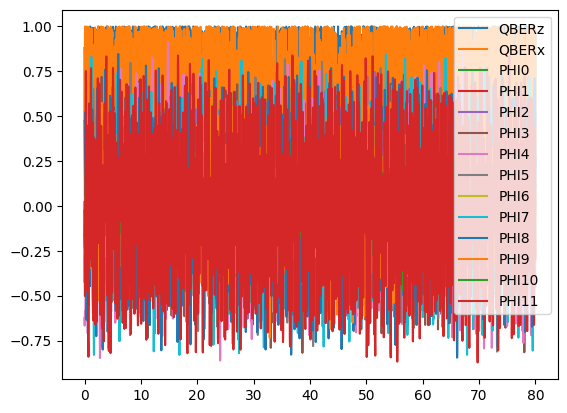

In [8]:
# plot data to make sure everything is ok
plt.plot(t_train, QBERs_train[:,0],label='QBERz')
plt.plot(t_train, QBERs_train[:,1],label='QBERx')
for i in range(12):
    plt.plot(t_train, phi_train[:,i],label=f'PHI{i}')
plt.legend(loc = 'upper right')

In [9]:
# Prepare the input data for RNN
phi_train = phi_train.reshape(phi_train.shape[0], 1, phi_train.shape[1])
phi_test = phi_test.reshape(phi_test.shape[0], 1, phi_test.shape[1])
QBERs_train = QBERs_train.reshape(QBERs_train.shape[0], 1, QBERs_train.shape[1])
QBERs_test = QBERs_test.reshape(QBERs_test.shape[0], 1, QBERs_test.shape[1])

print(phi_train.shape)
print(QBERs_train.shape)
print(t_train.shape)

(800000, 1, 12)
(800000, 1, 2)
(800000,)


# Test on a simple offset phi angle

In [53]:
# Define the offset value
offset = 0.1

# Prepare the input and output data for training
X_train = phi_train[:,0]
y_train = phi_train[:,0] + offset
X_test = phi_test[:,0]
y_test = phi_test[:,0] + offset

from sklearn.preprocessing import MinMaxScaler

# Create a scaler object
scaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
X_train = scaler.fit_transform(X_train.reshape(-1, 1))
y_train = scaler.transform(y_train.reshape(-1, 1))
X_test = scaler.transform(X_test.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16000, 1, 1)
(16000, 1, 1)
(6000, 1)
(6000, 1)


In [56]:
# Define the architecture of the LSTM model
model = keras.Sequential([
    keras.layers.LSTM(200, return_sequences=True, activation='relu', input_shape=(None, 1)),
    keras.layers.LSTM(100, activation='relu'),
    keras.layers.Dense(phi_train.shape[1])
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
500/500 [==============================] - 2s 3ms/step - loss: 0.0255
Epoch 2/10
500/500 [==============================] - 1s 3ms/step - loss: 2.4117e-04
Epoch 3/10
500/500 [==============================] - 1s 3ms/step - loss: 7.1010e-06
Epoch 4/10
500/500 [==============================] - 1s 3ms/step - loss: 1.4005e-06
Epoch 5/10
500/500 [==============================] - 1s 3ms/step - loss: 4.1204e-07
Epoch 6/10
500/500 [==============================] - 1s 3ms/step - loss: 2.3164e-07
Epoch 7/10
500/500 [==============================] - 1s 3ms/step - loss: 1.7557e-07
Epoch 8/10
500/500 [==============================] - 1s 3ms/step - loss: 1.7203e-07
Epoch 9/10
500/500 [==============================] - 1s 3ms/step - loss: 1.5424e-07
Epoch 10/10
500/500 [==============================] - 1s 3ms/step - loss: 1.7425e-07


In [57]:
phi_preds = model.predict(X_test)

188/188 [==============================] - 0s 1ms/step


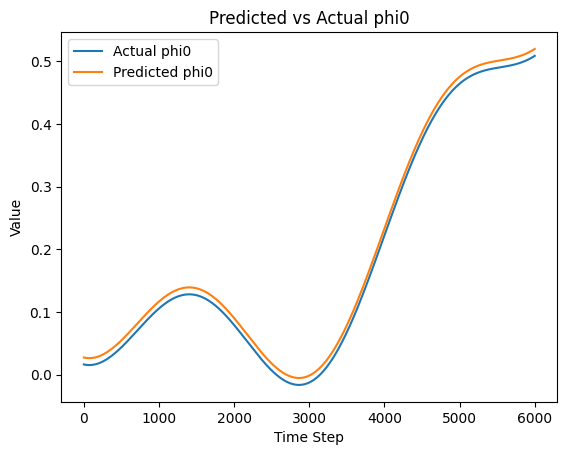

In [62]:
# Plot the predicted and actual values
for i in range(1):
    plt.plot(X_test[:, i], label=f'Actual phi{i}')
    plt.plot(y_test[:, i], label=f'Predicted phi{i}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(f'Predicted vs Actual phi{i}')
    plt.legend()
    plt.show()

# Test predict a single phi from QBER

In [13]:
def prepare_sequences(QBERs, phi, n_samples):
    QBERs_sequences = []
    phi_sequences = []
    for i in range(len(QBERs) - n_samples):
        QBERs_sequences.append(QBERs[i:i+n_samples])
        phi_sequences.append(phi[i+n_samples, 0])
    return np.array(QBERs_sequences).squeeze(), np.array(phi_sequences)

In [29]:
# Define the architecture of the LSTM model
model = keras.Sequential([
    keras.layers.LSTM(200, return_sequences=True, activation='relu', input_shape=(None, 2)),
    keras.layers.LSTM(100, activation='relu'),
    # keras.layers.Dense(16, activation='relu'),
    # keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='relu')
])

n_samples = 10
# QBERs_train_sequences, phi_train_sequences = prepare_sequences(QBERs_train, phi_train[:,0], n_samples)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(QBERs_train_sequences, phi_train_sequences, epochs=10, batch_size=64)
model.fit(QBERs_train, phi_train[:,:,0], epochs=1, batch_size=64)

 1023/12500 [=>............................] - ETA: 32s - loss: 0.0072

KeyboardInterrupt: 

In [27]:
phi_preds = model.predict(QBERs_test)

9375/9375 [==============================] - 8s 813us/step


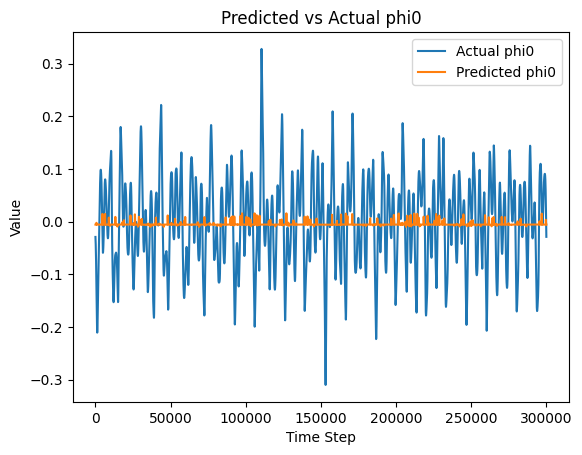

In [28]:
# Plot the predicted and actual values
plt.plot(phi_test[:, :, 0], label=f'Actual phi{0}')
plt.plot(phi_preds[:, 0], label=f'Predicted phi{0}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title(f'Predicted vs Actual phi{0}')
plt.legend()
plt.show()

# Section

In [ ]:
# # define how many variables
# num_inputs = 2

# # Define the sample size
# sample_size = 10

# # Create empty lists to store the input and output data
# X_train = []
# y_train = []

# # print(phi_train.shape)
# # Iterate over the training data
# for i in range(sample_size, len(QBERs_train)):
#     # Extract the current window of input data
#     window = QBERs_train[i-sample_size:i]
   
#     # Append the window and output to the training lists
#     X_train.append(window)
    
#     # output
#     # output = phi_train[i]
#     output = QBERs_train[i] + 0.1*np.ones((1,2))
#     y_train.append(output)

# X_train = np.array(X_train)
# y_train = np.array(y_train)

# # Iterate over the test data
# X_test = []
# y_test = []
# for i in range(sample_size, len(QBERs_test)):
#     window = QBERs_test[i-sample_size:i]
#     X_test.append(window)
#     # output = phi_test[i]
#     output = QBERs_test[i] + 0.1*np.ones((1,2))
#     y_test.append(output)

# X_test = np.array(X_test)
# y_test = np.array(y_test)

# # # Convert the training lists to numpy arrays
# # X_train = np.array(X_train).squeeze().reshape(len(X_train), sample_size, num_inputs)
# # y_train = np.array(y_train).squeeze().reshape(len(y_train), 1, 12)
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)

# # Define the architecture of the neural network
# model = keras.Sequential([
#     keras.layers.LSTM(200, return_sequences=True, activation='relu', input_shape=(None, num_inputs)),
#     # keras.layers.GRU(512, return_sequences=True, activation='tanh', kernel_initializer='glorot_normal'),
#     # keras.layers.LSTM(256, return_sequences=True, activation='relu', kernel_initializer='glorot_normal'),
#     keras.layers.LSTM(100, activation='relu'),
#     keras.layers.Dense(512, activation='relu'),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dense(12, activation='relu'),
#     keras.layers.Dense(2, activation='linear')
# ])
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mean_squared_error')

# # Use early stopping
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# # Use learning rate reduction on plateau
# lr_reduction = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5)

(4790, 10, 2)
(4790, 1, 2)
(1790, 10, 2)
(1790, 1, 2)


In [ ]:
import numpy as np
from tensorflow import keras

# Define the input shape
input_shape = 3

# Define the number of output units
output_units = 1

# Define the architecture of the neural network
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(input_shape,)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(output_units)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

X = np.concatenate((QBERs_train, t_train.reshape(-1,1)), axis=1)

# Train the model
model.fit(X, phi_train[:, 0], epochs=10, batch_size=32)

Y = np.concatenate((QBERs_test, t_test.reshape(-1,1)), axis=1)

# Evaluate the model
loss = model.evaluate(Y, phi_test[:, 0])
print("Test loss:", loss)

# Make predictions
phi_preds = model.predict(Y)


Epoch 1/10
150/150 [==============================] - 0s 982us/step - loss: 0.6564
Epoch 2/10
150/150 [==============================] - 0s 825us/step - loss: 0.2390
Epoch 3/10
150/150 [==============================] - 0s 825us/step - loss: 0.1420
Epoch 4/10
150/150 [==============================] - 0s 938us/step - loss: 0.1034
Epoch 5/10
150/150 [==============================] - 0s 826us/step - loss: 0.0649
Epoch 6/10
150/150 [==============================] - 0s 834us/step - loss: 0.0232
Epoch 7/10
150/150 [==============================] - 0s 831us/step - loss: 0.0048
Epoch 8/10
150/150 [==============================] - 0s 819us/step - loss: 0.0014
Epoch 9/10
150/150 [==============================] - 0s 821us/step - loss: 9.4053e-04
Epoch 10/10
57/57 [==============================] - 0s 806us/step - loss: 0.7623
Test loss: 0.7623310089111328
57/57 [==============================] - 0s 692us/step


In [ ]:
# Train the neural network
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, callbacks=[early_stopping, lr_reduction], validation_split=0.2)

Epoch 1/10
39/39 [==============================] - 2s 27ms/step - loss: 0.0373 - val_loss: 0.0161 - lr: 0.0010
Epoch 2/10
39/39 [==============================] - 1s 23ms/step - loss: 0.0128 - val_loss: 0.0182 - lr: 0.0010
Epoch 3/10
39/39 [==============================] - 1s 21ms/step - loss: 0.0126 - val_loss: 0.0188 - lr: 0.0010
Epoch 4/10
39/39 [==============================] - 1s 21ms/step - loss: 0.0126 - val_loss: 0.0210 - lr: 0.0010
Epoch 5/10
39/39 [==============================] - 1s 21ms/step - loss: 0.0126 - val_loss: 0.0212 - lr: 0.0010
Epoch 6/10
39/39 [==============================] - 1s 21ms/step - loss: 0.0127 - val_loss: 0.0200 - lr: 0.0010
Epoch 7/10
39/39 [==============================] - 1s 21ms/step - loss: 0.0126 - val_loss: 0.0230 - lr: 0.0010
Epoch 8/10
39/39 [==============================] - 1s 21ms/step - loss: 0.0126 - val_loss: 0.0194 - lr: 0.0010
Epoch 9/10
39/39 [==============================] - 1s 21ms/step - loss: 0.0125 - val_loss: 0.0202 - lr:

In [ ]:
# Predict the QBER using the trained neural network
phi_preds = model.predict(X_test[:,:], batch_size=100)

# Convert the predicted_phi_move to a numpy array
phi_preds = np.array(phi_preds)

18/18 [==============================] - 0s 8ms/step


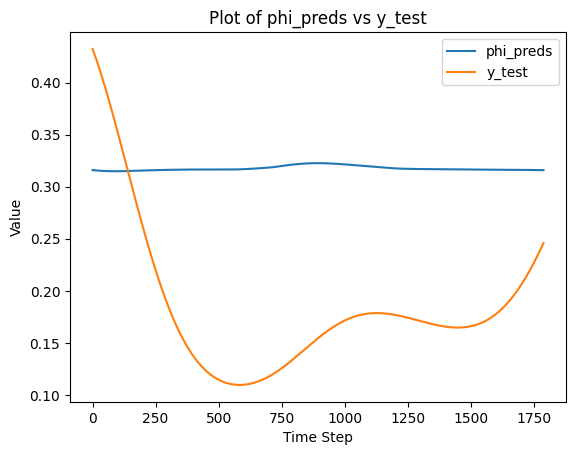

In [ ]:
plt.plot(phi_preds[:, 0], label='phi_preds')
plt.plot(y_test[:, 0, 0], label='y_test')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Plot of phi_preds vs y_test')
plt.legend()
plt.show()


In [ ]:
# phi_preds = phi_preds.reshape(phi_preds.shape[0], phi_preds.shape[2])
print(phi_preds.shape)
phi_test = phi_test.reshape(phi_test.shape[0], phi_test.shape[2])
print(phi_test.shape)

(300000, 1)


IndexError: tuple index out of range

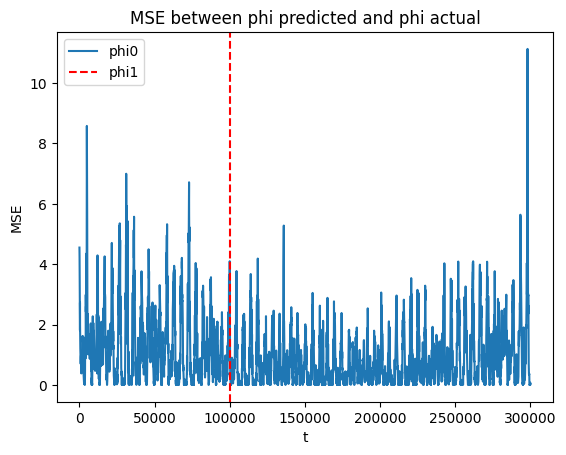

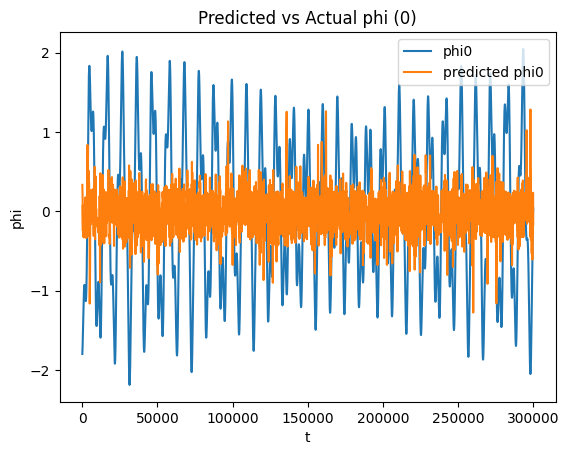

In [ ]:
# Plot the MSE
for j in range(1):
    mse_values = []
    for i in range(len(phi_preds)):
        mse = np.mean((phi_preds[i,j] - phi_test[i,j]) ** 2)
        mse_values.append(mse)

    plt.plot(mse_values)
plt.axvline(x=len(PHI) * 0.1, color='red', linestyle='--')
plt.xlabel('t')
plt.ylabel('MSE')
plt.legend(loc='upper left', labels=[f'phi{i}' for i in range(12)])
plt.title('MSE between phi predicted and phi actual')
plt.show()

phi_plot = np.array(PHI)
phi_test = np.array(phi_test)
phi_preds = np.array(phi_preds)
# # Plot the predicted and actual phi
for i in range(1):
    # plt.axvline(x=len(phi_plot) * 0.1, color='red', linestyle='--')
    plt.plot(phi_test[:,i], label=f'phi{i}')
    plt.plot(phi_preds[:,i], label=f'predicted phi{i}')
    plt.xlabel('t')
    plt.ylabel('phi')
    plt.legend(loc='upper right')
    plt.title(f'Predicted vs Actual phi ({i})')
    plt.show()

In [ ]:
QBER_2 = QBER.reshape(QBER.shape[0], 1, QBER.shape[1])
# Predict the QBER using the trained neural network
phi_preds = model.predict(QBER_2[:,:])
phi_preds = np.array(phi_preds)
phi_preds = phi_preds.reshape(phi_preds.shape[0], phi_preds.shape[2])

1751/1751 [==============================] - 3s 1ms/step


IndexError: tuple index out of range

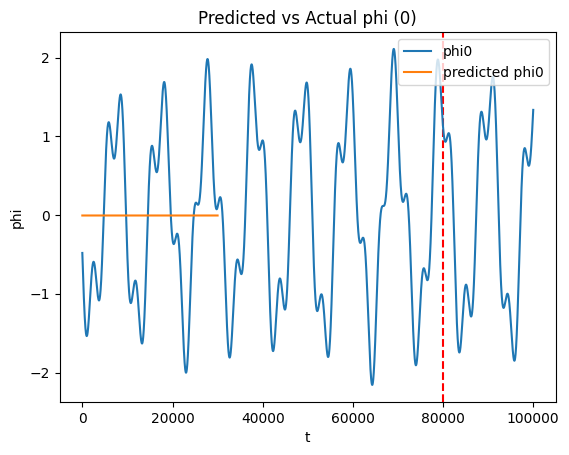

IndexError: index 1 is out of bounds for axis 1 with size 1

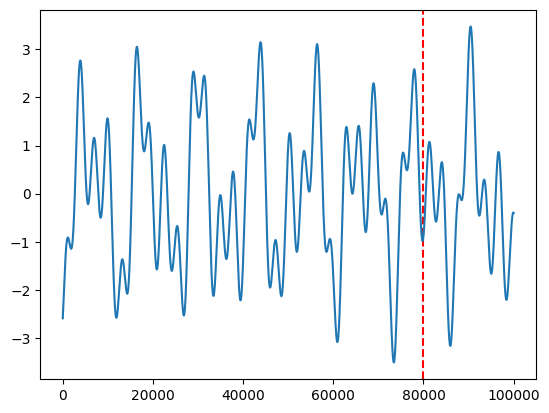

In [ ]:

# # Plot the predicted and actual phi
for i in range(12):
    plt.axvline(x=len(phi_plot) * split, color='red', linestyle='--')
    plt.plot(PHI[:,i], label=f'phi{i}')
    plt.plot(phi_preds[:,i], label=f'predicted phi{i}')
    plt.xlabel('t')
    plt.ylabel('phi')
    plt.legend(loc='upper right')
    plt.title(f'Predicted vs Actual phi ({i})')
    plt.show()